# Problem Description: Darcy Flow
**Governing PDE: $\quad −∇⋅(k(x,y)∇u(x,y))=f(x,y),x∈[0,1]$**


**Boundary Condition: $\quad u_{bc}(x,y) = 0, \quad x,y \in [0,1]$**

**Solution Operator: $G : k(x,y) \mapsto u(x,y)$**

branch net 입력: k(x,y)의 센서값</br>
trunk net 입력: x,y 그리드 좌표</br>
출력: 전체 압력장 u(x,y)

Reference: https://github.com/neuraloperator/neuraloperator/tree/main

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from neuralop.data.datasets import DarcyDataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:0


In [4]:
import neuralop.data.datasets as nd
print(dir(nd))

['Burgers1dTimeDataset', 'CarCFDDataset', 'DarcyDataset', 'DictDataset', 'MeshDataModule', 'NavierStokesDataset', 'PTDataset', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'burgers', 'car_cfd_dataset', 'darcy', 'dict_dataset', 'load_darcy_flow_small', 'load_mini_burgers_1dtime', 'load_mini_car', 'load_navier_stokes_pt', 'mesh_datamodule', 'navier_stokes', 'pt_dataset', 'tensor_dataset', 'web_utils']


In [ ]:
# 데이터셋 생성 및 로더 설정
dataset = DarcyDataset(
    root_dir="C:/Users/admin/Desktop/김도형/코드/Dataset",
    n_train=2000, n_tests=[20, 20, 20],
    batch_size=50, test_batch_sizes=[20, 20, 20],
    train_resolution=32, test_resolutions=[16, 32, 64],
    download=True
)

train_loader = DataLoader(dataset.train_db, batch_size=50, shuffle=True, 
                          num_workers=2, pin_memory=True)
test_loaders = {res: DataLoader(db, batch_size=20, shuffle=False,
                                num_workers=2, pin_memory=True) 
                for res, db in dataset.test_dbs.items()}

c:\Users\admin\AppData\Local\anaconda3\envs\py311\Lib\site-packages\neuralop\data\datasets\pt_dataset.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load

Loading test db for resolution 16 with 20 samples 
Loading test db for resolution 32 with 20 samples 
Loading test db for resolution 64 with 20 samples 


In [6]:
batch = next(iter(train_loader))
print(batch.keys())
for k, v in batch.items():
    print(k, v.shape)

x_data = batch['x'].view(batch['x'].size(0), -1)
print(x_data.shape)

dict_keys(['x', 'y'])
x torch.Size([50, 1, 32, 32])
y torch.Size([50, 1, 32, 32])
torch.Size([50, 1024])


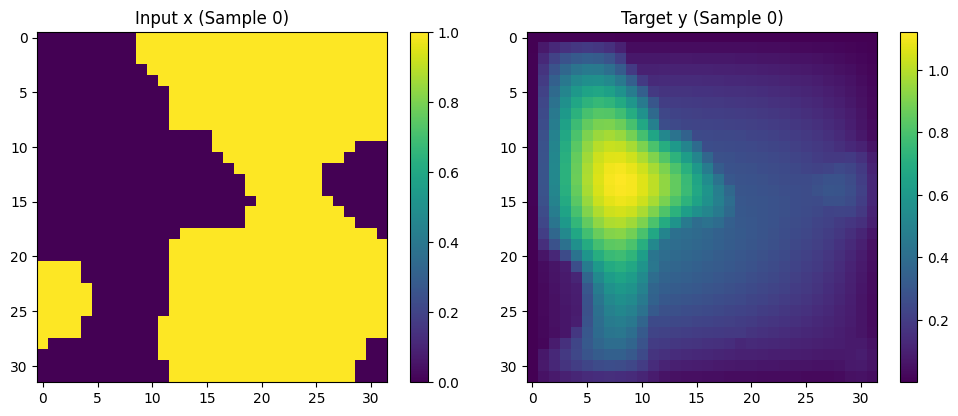

In [7]:
# 샘플 시각화
x_samples, y_samples = batch['x'], batch['y']
sample_idx = 0

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(x_samples[sample_idx].squeeze(), cmap='viridis')
axes[0].set_title(f"Input x (Sample {sample_idx})")
axes[0].figure.colorbar(axes[0].images[0], ax=axes[0])

axes[1].imshow(y_samples[sample_idx].squeeze(), cmap='viridis')
axes[1].set_title(f"Target y (Sample {sample_idx})")
axes[1].figure.colorbar(axes[1].images[0], ax=axes[1])

plt.tight_layout()
plt.show()

In [8]:
# trunk 좌표 및 데이터 준비
xs = torch.linspace(0.0, 1.0, 32)
ys = torch.linspace(0.0, 1.0, 32)
X, Y = torch.meshgrid(xs, ys, indexing="ij")
trunk = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1).to(batch["x"].device)

# 데이터 준비 및 정규화
branch_flat = batch["x"].flatten(1)
Y_flat = batch["y"].flatten(1)

print(f'branch: {branch_flat.shape}, trunk: {trunk.shape}, Y: {Y_flat.shape}')

branch: torch.Size([50, 1024]), trunk: torch.Size([1024, 2]), Y: torch.Size([50, 1024])


In [9]:
class DeepONetDataset(Dataset):
    def __init__(self, data_loader, trunk_coords):
        self.branch_data = []
        self.target_data = []
        
        for batch in data_loader:
            B = batch["x"].size(0)
            branch_flat = batch["x"].view(B, -1)
            Y_flat = batch["y"].view(B, -1)
            self.branch_data.append(branch_flat)
            self.target_data.append(Y_flat)
        
        self.branch_data = torch.cat(self.branch_data, dim=0)
        self.target_data = torch.cat(self.target_data, dim=0)
        
        self.trunk = trunk_coords
    
    def __len__(self):
        return len(self.branch_data)
    
    def __getitem__(self, index):
        return self.branch_data[index], self.target_data[index]

In [10]:
# 학습용 데이터셋 생성
train_dataset = DeepONetDataset(train_loader, trunk)
train_loader_fast = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=0, pin_memory=True)

In [11]:
class Network(torch.nn.Module):
    def __init__(self, branch_dim=1024, trunk_dim=2, hidden_dim=512, hidden_dim2=256, hidden_dim3=128, output_dim=256):
        super().__init__()
        self.bias = nn.Parameter(torch.tensor(0.0))

        self.branch = nn.Sequential(
            nn.Linear(branch_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim2), nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim2), nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3), nn.ReLU(),
            nn.Linear(hidden_dim3, output_dim)
        )

        self.trunk = nn.Sequential(
            nn.Linear(trunk_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim2), nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim2), nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3), nn.ReLU(),
            nn.Linear(hidden_dim3, output_dim)
        )
    
    def forward(self, branch, trunk):
        branch_out = self.branch(branch)
        trunk_out  = self.trunk(trunk)
        out = branch_out @ trunk_out.T + self.bias
        return out

def init_weights(m): 
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data) 
        nn.init.zeros_(m.bias)

In [12]:
model = Network()
model.apply(init_weights)
model = model.to(device)

In [13]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [89]:
# 학습
n_epochs = 10000

trunk = trunk.to(device)

for epoch in range(n_epochs):
    model.train()
    losses = []
    
    for branch_batch, Y_batch in train_loader_fast:
        branch_batch = branch_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        optimizer.zero_grad()
        pred = model(branch_batch, trunk)
        loss = loss_fn(pred, Y_batch)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    if epoch % 1000 == 0:
        avg_loss = np.mean(losses)
        print(f'Epoch: {epoch}, Loss: {avg_loss:.4f}')
        torch.save(model.state_dict(), "C:/Users/admin/Desktop/김도형/코드/model/darcy_deeponet_mlp_autosave.pt")

Epoch: 0, Loss: 0.1336
Epoch: 1000, Loss: 0.0008
Epoch: 2000, Loss: 0.0007
Epoch: 3000, Loss: 0.0007
Epoch: 4000, Loss: 0.0007
Epoch: 5000, Loss: 0.0009
Epoch: 6000, Loss: 0.0010
Epoch: 7000, Loss: 0.0008
Epoch: 8000, Loss: 0.0008
Epoch: 9000, Loss: 0.0011


In [14]:
test_batch = next(iter(test_loaders[32]))
print(test_batch.keys())
for k, v in test_batch.items():
    print(k, v.shape)

test_x_data = test_batch['x'].view(test_batch['x'].size(0), -1)
print(test_x_data.shape)

dict_keys(['x', 'y'])
x torch.Size([20, 1, 32, 32])
y torch.Size([20, 1, 32, 32])
torch.Size([20, 1024])


In [131]:
# 예측 및 시각화
idx = 0

k_sample = test_batch["x"][idx:idx+1].to(device)
u_true_raw = test_batch["y"][idx:idx+1].to(device)

model.eval()

with torch.no_grad():
    branch_flat = k_sample.flatten(1)
    u_pred_norm = model(branch_flat, trunk)
    
    u_pred = u_pred_norm.view(1, 1, 32, 32)

# numpy 변환
k_np = k_sample.squeeze().cpu().numpy()
u_true_np = u_true_raw.squeeze().cpu().numpy()
u_pred_np = u_pred.squeeze().cpu().numpy()
u_err = np.abs(u_pred_np - u_true_np)

# 상대 오차
rel_l2 = np.linalg.norm(u_true_np - u_pred_np) / (np.linalg.norm(u_true_np) + 1e-12) * 100
print(f"Relative L2 Error: {rel_l2:.2f}%")

# 시각화
fig, axes = plt.subplots(1, 4, figsize=(22, 5))
extent = [0, 1, 0, 1]

axes[0].imshow(k_np.T, origin="lower", cmap="viridis", extent=extent)
axes[0].set_title(f"Input $k$ (Sample {idx})")
plt.colorbar(axes[0].images[0], ax=axes[0])

axes[1].imshow(u_true_np.T, origin="lower", cmap="viridis", extent=extent)
axes[1].set_title("True $u$")
plt.colorbar(axes[1].images[0], ax=axes[1])

axes[2].imshow(u_pred_np.T, origin="lower", cmap="viridis", extent=extent)
axes[2].set_title("Pred $u$")
plt.colorbar(axes[2].images[0], ax=axes[2])

axes[3].imshow(u_err.T, origin="lower", cmap="viridis", extent=extent)
axes[3].set_title(f"Error (Rel L2: {rel_l2:.2f}%)")
plt.colorbar(axes[3].images[0], ax=axes[3])

plt.tight_layout()
plt.savefig(f"C:/Users/admin/Desktop/김도형/코드/figure_20260213_labmeeting/sample_{idx}_result_mlp.png", dpi=300, bbox_inches="tight")
plt.show()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
model.eval()
all_rel_l2_errors = []

# 테스트 배치가 단일 텐서 묶음인 경우를 가정 (test_batch["x"], test_batch["y"])
with torch.no_grad():
    # 데이터를 모델 장치로 이동
    x_test = test_batch["x"].to(device)
    y_true = test_batch["y"].to(device)
    
    # 1. 모델 예측 (Flat 형태 처리)
    branch_flat = x_test.flatten(1)
    u_pred_norm = model(branch_flat, trunk)
    
    # 2. 형태 복원 (Batch size, 32, 32 등)
    # y_true의 shape에 맞춰 자동으로 view를 조정합니다.
    u_pred = u_pred_norm.view(y_true.shape)

    # 3. 각 샘플별로 Relative L2 Error 계산
    # u_true와 u_pred는 (N, H, W) 또는 (N, 1, H, W) 형태여야 합니다.
    for i in range(len(x_test)):
        true_sample = y_true[i].cpu().numpy()
        pred_sample = u_pred[i].cpu().numpy()
        
        diff_norm = np.linalg.norm(true_sample - pred_sample)
        true_norm = np.linalg.norm(true_sample)
        
        # 분모가 0이 되는 것을 방지하기 위해 1e-12 추가
        rel_l2 = (diff_norm / (true_norm + 1e-12)) * 100
        all_rel_l2_errors.append(rel_l2)

# 4. 최종 통계량 산출
mean_rel_l2 = np.mean(all_rel_l2_errors)
std_rel_l2 = np.std(all_rel_l2_errors)
max_rel_l2 = np.max(all_rel_l2_errors)
min_rel_l2 = np.min(all_rel_l2_errors)

print("-" * 30)
print(f"Total Samples: {len(all_rel_l2_errors)}")
print(f"Mean Relative L2 Error: {mean_rel_l2:.4f}%")
print(f"Std Deviation: {std_rel_l2:.4f}%")
print(f"Min Error: {min_rel_l2:.4f}%")
print(f"Max Error: {max_rel_l2:.4f}%")
print("-" * 30)

------------------------------
Total Samples: 20
Mean Relative L2 Error: 18.7663%
Std Deviation: 5.4069%
Min Error: 10.5464%
Max Error: 26.8827%
------------------------------


In [ ]:
import torch
import numpy as np

model.eval()

# 테스트 데이터 준비
x_test = test_batch["x"].to(device)
y_true = test_batch["y"].to(device)

with torch.no_grad():
    # 전체 데이터에 대한 예측 수행
    branch_flat = x_test.flatten(1)
    u_pred_norm = model(branch_flat, trunk)
    
    # 예측값의 shape을 실제 정답(y_true)과 동일하게 변환
    u_pred = u_pred_norm.view(y_true.shape)

print(f"{'Sample Index':<15} | {'Relative L2 Error (%)':<20}")
print("-" * 40)

# 모든 샘플을 순회하며 개별 오차 출력
for i in range(len(x_test)):
    # 각 샘플 추출 및 numpy 변환
    true_sample = y_true[i].cpu().numpy()
    pred_sample = u_pred[i].cpu().numpy()
    
    # Relative L2 Error 계산: ||u_true - u_pred|| / ||u_true||
    diff_norm = np.linalg.norm(true_sample - pred_sample)
    true_norm = np.linalg.norm(true_sample)
    
    # 분모가 0인 경우를 대비해 아주 작은 값(1e-12)을 더해줌
    rel_l2 = (diff_norm / (true_norm + 1e-12)) * 100
    
    # 결과 출력
    print(f"Sample {i:<8} | {rel_l2:.4f}%")

print("-" * 40)
print(f"Total samples processed: {len(x_test)}")

Sample Index    | Relative L2 Error (%)
----------------------------------------
Sample 0        | 14.5928%
Sample 1        | 10.5464%
Sample 2        | 23.6820%
Sample 3        | 16.6557%
Sample 4        | 18.7936%
Sample 5        | 26.8827%
Sample 6        | 25.4070%
Sample 7        | 26.5543%
Sample 8        | 12.2832%
Sample 9        | 18.7770%
Sample 10       | 11.3782%
Sample 11       | 26.6909%
Sample 12       | 16.2806%
Sample 13       | 23.5650%
Sample 14       | 23.8392%
Sample 15       | 13.6671%
Sample 16       | 20.7907%
Sample 17       | 14.1859%
Sample 18       | 17.8321%
Sample 19       | 12.9224%
----------------------------------------
Total samples processed: 20



[C:/Users/admin/Desktop/김도형/코드/model/darcy_deeponet_mlp_autosave.pt] 모델 테스트 중... (Target Res: 16x16)


C:\Users\admin\AppData\Local\Temp\ipykernel_10224\589711346.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


총 테스트 샘플 수: 20
전체 샘플 Relative L2 Error: ['17.47%', '14.21%', '21.66%', '18.16%', '27.18%', '26.45%', '26.57%', '19.37%', '18.64%', '20.84%', '10.11%', '22.38%', '25.14%', '29.53%', '27.27%', '20.63%', '20.68%', '19.36%', '20.65%', '17.72%']
평균 Relative L2 Error: 21.20%


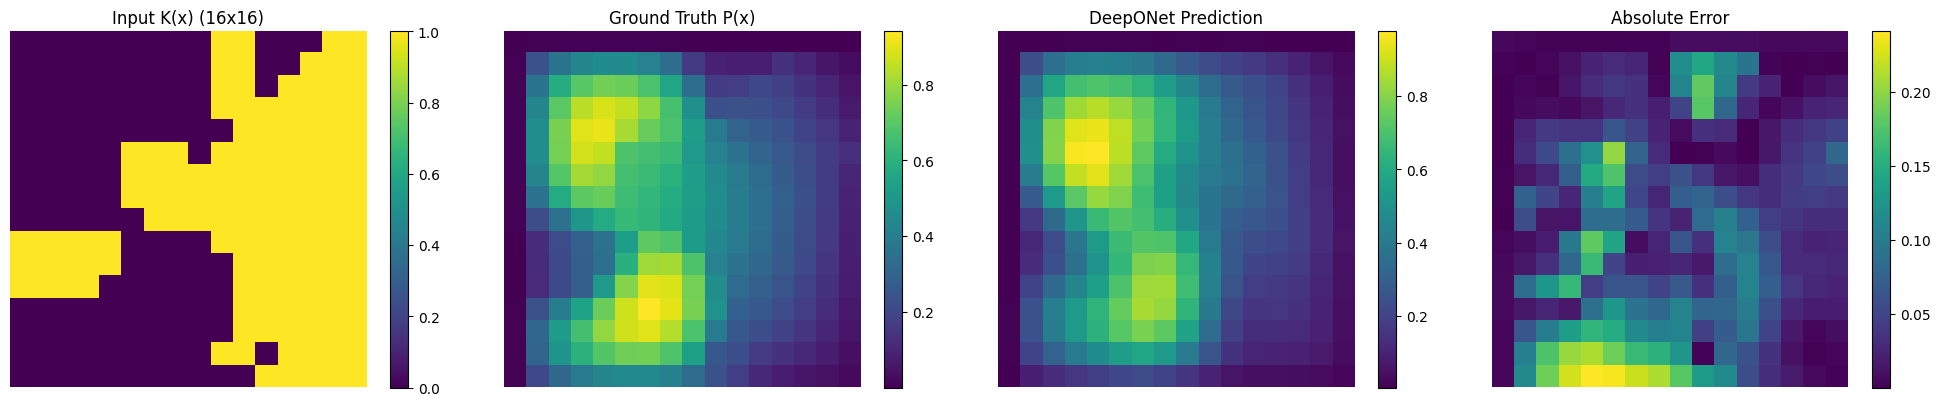

------------------------------------------------------------

[C:/Users/admin/Desktop/김도형/코드/model/darcy_deeponet_mlp_autosave.pt] 모델 테스트 중... (Target Res: 32x32)
총 테스트 샘플 수: 20
전체 샘플 Relative L2 Error: ['13.98%', '10.75%', '24.95%', '17.73%', '19.03%', '26.04%', '26.67%', '26.54%', '13.45%', '19.33%', '11.75%', '24.77%', '17.00%', '23.65%', '23.57%', '15.25%', '20.85%', '14.41%', '17.74%', '13.90%']
평균 Relative L2 Error: 19.07%


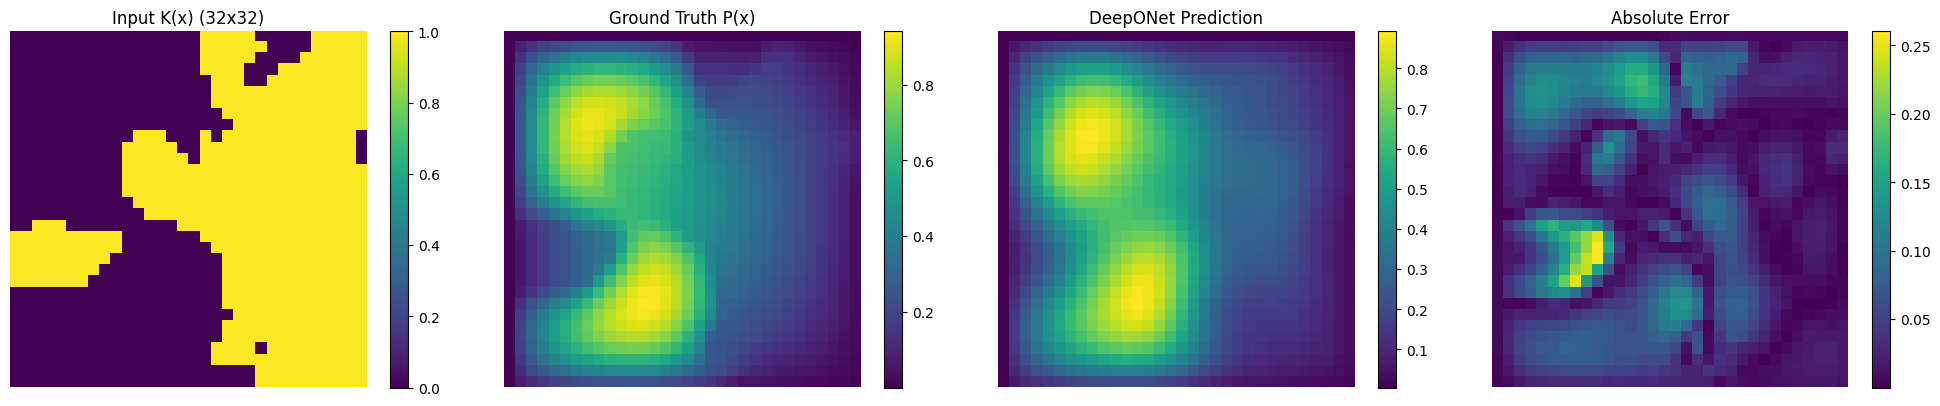

------------------------------------------------------------

[C:/Users/admin/Desktop/김도형/코드/model/darcy_deeponet_mlp_autosave.pt] 모델 테스트 중... (Target Res: 64x64)
총 테스트 샘플 수: 20
전체 샘플 Relative L2 Error: ['13.19%', '12.92%', '23.76%', '21.00%', '21.19%', '27.77%', '27.66%', '27.65%', '17.71%', '20.18%', '14.10%', '29.70%', '14.75%', '25.18%', '25.65%', '16.10%', '17.59%', '14.94%', '17.12%', '15.35%']
평균 Relative L2 Error: 20.18%


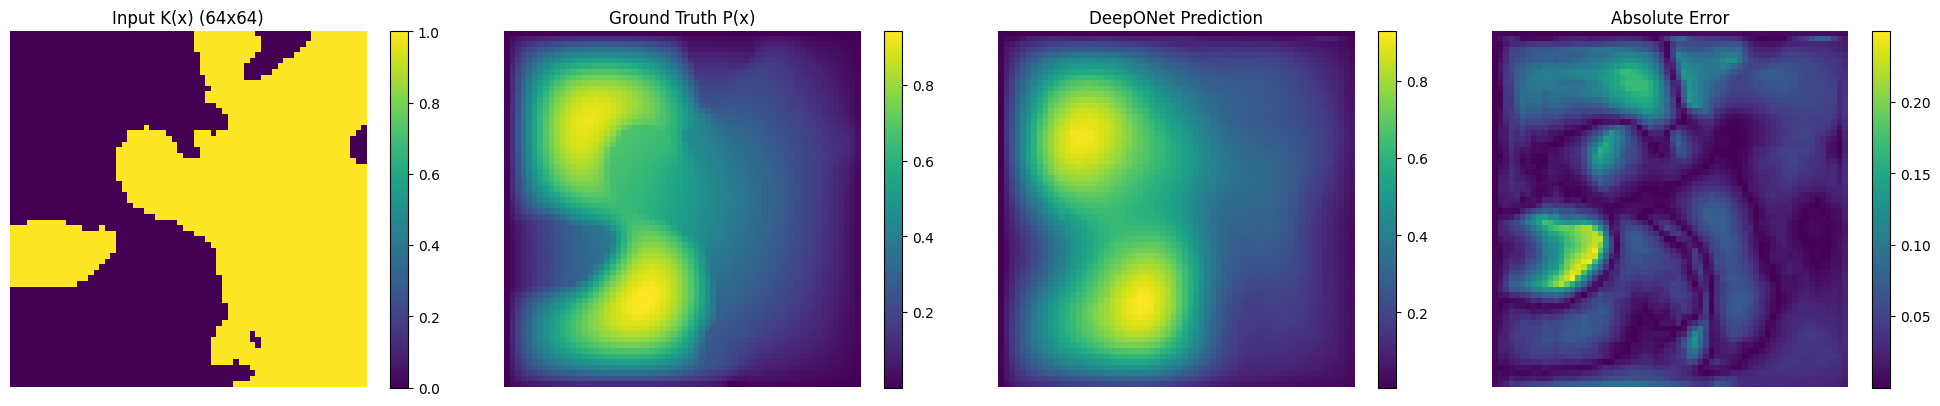

------------------------------------------------------------


In [134]:
import torch.nn.functional as F
def test_model(model_path, resolution, data_loader):
    """
    특정 모델 파일과 해상도에 대해 테스트를 수행하는 함수
    """
    print(f"\n[{model_path}] 모델 테스트 중... (Target Res: {resolution}x{resolution})")
    
    # 모델 초기화
    model = Network(branch_dim=1024, trunk_dim=2).to(device)
    
    # 가중치 로드
    try:
        checkpoint = torch.load(model_path, map_location=device)
        if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
            model.load_state_dict(checkpoint['state_dict'])
        elif isinstance(checkpoint, dict):
            model.load_state_dict(checkpoint)
        else: # 모델 전체가 저장된 경우
            model = checkpoint
        model.eval()
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # Trunk 좌표 생성 (테스트 해상도에 맞춤)
    trunk_input = get_trunk_coords(resolution)
    
    l2_errors = []
    vis_input, vis_true, vis_pred = None, None, None
    
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            x = batch['x'].to(device) # (Batch, 1, Res, Res)
            y = batch['y'].to(device) # (Batch, 1, Res, Res)
            
            # --- Branch 입력 전처리 (DeepONet 핵심) ---
            # Branch Net은 학습 시 32x32(1024) 입력으로 고정되어 있으므로
            # 다른 해상도가 들어오면 32x32로 보간(Interpolation)해야 함
            if x.shape[-1] != 32:
                x_branch = F.interpolate(x, size=(32, 32), mode='bilinear', align_corners=False)
            else:
                x_branch = x
            
            # (Batch, 1024) 형태로 평탄화
            branch_input = x_branch.view(x.size(0), -1)
            
            # 예측 (Batch, Res*Res)
            out_flat = model(branch_input, trunk_input)
            
            # 정답 평탄화 (Batch, Res*Res)
            true_flat = y.view(y.size(0), -1)
            
            # Relative L2 Error 계산
            diff_norm = torch.norm(out_flat - true_flat, p=2, dim=1)
            true_norm = torch.norm(true_flat, p=2, dim=1)
            batch_errors = diff_norm / (true_norm + 1e-6)
            
            l2_errors.extend(batch_errors.cpu().tolist())
            
            # 시각화용 데이터 저장 (첫 배치 첫 샘플)
            if i == 0:
                vis_input = x[0, 0].cpu().numpy()
                vis_true = y[0, 0].cpu().numpy()
                vis_pred = out_flat[0].view(resolution, resolution).cpu().numpy()

    # 결과 텍스트 출력
    avg_error = np.mean(l2_errors)
    
    print(f"총 테스트 샘플 수: {len(l2_errors)}")
    # 요청하신 포맷: ['00.00%', ...]
    formatted_errors = [f"{e*100:05.2f}%" for e in l2_errors]
    print(f"전체 샘플 Relative L2 Error: {formatted_errors}")
    print(f"평균 Relative L2 Error: {avg_error*100:.2f}%")
    
    # 결과 시각화
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    abs_error = np.abs(vis_true - vis_pred)
    
    titles = [f'Input K(x) ({resolution}x{resolution})', 
              'Ground Truth P(x)', 
              'DeepONet Prediction', 
              'Absolute Error']
    images = [vis_input, vis_true, vis_pred, abs_error]
    
    for ax, img, title in zip(axes, images, titles):
        im = ax.imshow(img, cmap='viridis')
        ax.set_title(title)
        plt.colorbar(im, ax=ax)
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(f"C:/Users/admin/Desktop/김도형/코드/figure_20260213_labmeeting/result_don_mlp_sample_{resolution}.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("-" * 60)

model_file = "C:/Users/admin/Desktop/김도형/코드/model/darcy_deeponet_mlp_autosave.pt"

test_model(model_file, 16, test_loaders[16])
test_model(model_file, 32, test_loaders[32])
test_model(model_file, 64, test_loaders[64])